In [1]:
import requests
import sys
sys.path.append('src')
from paco.parser.parse_tree import ParseTree
from paco.execution_tree.execution_tree import ExecutionTree
from paco.explainer.bdd.bdds import bdds_from_json

headers = {
	"Content-Type": "application/json",
}
url = "http://127.0.0.1:8000/"

## Read a bundle from the CPI dataset

In [2]:
import random
from experiments.etl.read import read_cpi_bundles
from experiments.etl.cpi_translations import cpi_to_standard_format

x = 1
y = 1
bundles = read_cpi_bundles(x=x,y=y)
print("Size: ", len(bundles))

w = random.randint(0, len(bundles)-1)
print(f"x={x}, y={y}, w={w}")
bpmn = cpi_to_standard_format(bundles[w])
bpmn

Size:  5400
x=1, y=1, w=3521


{'expression': '(T1 ^[N1] T2)',
 'impacts_names': ['impact_1',
  'impact_2',
  'impact_3',
  'impact_4',
  'impact_5',
  'impact_6'],
 'impacts': {'T1': [0.0, 2.5527241603828865e-07, 0.0, 0.0, 0.0, 0.0],
  'T2': [4.639962837949153e-06, 0.06061279282848599, 0.0, 0.0, 0.0, 0.0]},
 'durations': {'T1': [0, 9], 'T2': [0, 2]},
 'probabilities': {'N1': 0.3032627933017975},
 'delays': {},
 'loop_round': {},
 'loop_probability': {},
 'h': 0}

### Check BPMN

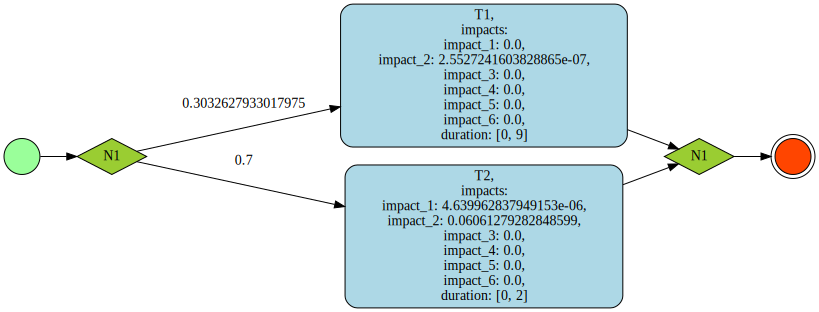

In [3]:
import graphviz
from IPython.display import display, SVG

try:
	resp = requests.get(f'{url}create_bpmn', json={'bpmn': bpmn},  headers=headers)
	resp.raise_for_status()
	display(SVG(graphviz.Source(resp.json()['bpmn_dot']).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

### Create the Execution tree

In [4]:
execution_tree = None
try:
	resp = requests.get(f'{url}create_execution_tree', json={"bpmn": bpmn},  headers=headers)
	resp.raise_for_status()

	response = resp.json()
	parse_tree, _,_ = ParseTree.from_json(response["parse_tree"], len(bpmn["impacts_names"]), 0)

	bound = parse_tree.sample_expected_impact()
	print(f"Sampled Expected Impact: {bound}")

	execution_tree = ExecutionTree.from_json(parse_tree, response["execution_tree"], bpmn["impacts_names"])
	dot = execution_tree.to_dot(state=True, executed_time=True, diff=True)
	display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

ValueError: Unsupported node type: nature

In [ ]:
try:
	resp = requests.get(f'{url}create_strategy', json={"bpmn": bpmn, "bound": bound, "parse_tree": parse_tree.to_dict(), "execution_tree": execution_tree.to_dict()}, headers=headers)
	resp.raise_for_status()

	response = resp.json()
	print(response["result"])

	frontier_solution_id = set()
	if "frontier_solution" in response: # Solution Found
		frontier_solution_id = set(map(int, response["frontier_solution"].strip("[]").split(",")))

	# With frontier node in blue
	dot = execution_tree.to_dot(state=True, executed_time=False, diff=True, frontier=frontier_solution_id)
	display(SVG(graphviz.Source(dot).pipe(format="svg")))

	if "strategy_tree" in response:
		explained_choices = bdds_from_json(parse_tree, response["bdds"])
		print("1 is dashed line of BPMN or Parse Tree")
		for choice, bdd in explained_choices.items():
			print(f"{choice.name}: {bdd.typeStrategy}")
			svg_data = graphviz.Source(bdd.bdd_to_dot()).pipe(format="svg")
			display(SVG(svg_data))

		strategy_tree = ExecutionTree.from_json(parse_tree, response["strategy_tree"], bpmn["impacts_names"], explained_choices)

		#TREE_STATE
		dot = strategy_tree.to_dot(state=True, executed_time=False, diff=True)
		display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())